In [1]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import networkx as nx
from orinoco import (get_distance_in_channel,
                     get_distance_segments,
                     get_undirected_channel_network,
                     direct_channel_network,
                     export_edges_to_geodataframe,
                     export_nodes_to_geodataframe,
                     get_map_centroid_from_binary_mask,
                     add_flow_attributes,
                     split_tuple_pairs,
                     get_segment_df,
                     get_geo_width_df,
                     update_graph_with_widths,
                     get_width_features_from_segments,
                     add_width_features_to_graph,
                     get_array_from_features
                     )
from skimage.color import label2rgb
import random
import geopandas as gpd
from shapely.geometry import Point

# Initialize the Tile Directory

In [2]:
site_name = 'mackenzie'

In [3]:
site_dir = Path(f'out/{site_name}')
site_dir.exists()

True

# Read Data from the Tile Directory

In [4]:
with rasterio.open(site_dir/f'water_mask_{site_name}.tif') as ds:
    water_mask = ds.read(1)
with rasterio.open(site_dir/f'ocean_mask_{site_name}.tif') as ds:
    ocean_mask = ds.read(1)
    profile = ds.profile

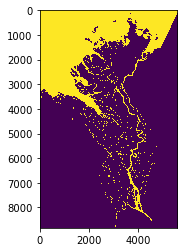

In [5]:
plt.imshow(water_mask, interpolation='none')

# Generate Orinoco Products

## Obtaining the Distance Function

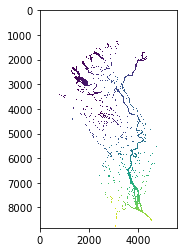

In [6]:
transform = profile['transform']
dx, dy = transform.a, -transform.e
dist = get_distance_in_channel(water_mask,
                               ocean_mask,
                               dx=dx,
                               dy=dy,
                               # removes areas with less than percentage of total size
                               min_rel_area=0.025,
                               # Applys a 1 pixel buffer for distance computation
                               # for artifical 8-connectivity.
                               # See: https://github.com/scikit-fmm/scikit-fmm/issues/32
                               # Removes buffer after computation complete.
                               # Only recommended for validation here
                               apply_mask_buffer=True
                              )
plt.imshow(dist, interpolation='none')

Save the distance product.

In [7]:
p = profile.copy()
p['dtype'] = 'float32'
with rasterio.open(site_dir/f'distance_{site_name}.tif', 'w', **p) as ds:
    ds.write(dist.astype(np.float32), 1)

## Segmentation of the Channel

In [8]:
pixel_step = 5
segments, interface_adj_segments = get_distance_segments(dist,
                                                         pixel_step,
                                                         dx=dx,
                                                         dy=dy,
                                                         connectivity=8,
                                                         min_size=4)

rag neighbors: 100%|██████████| 840/840 [00:00<00:00, 23876.66it/s]


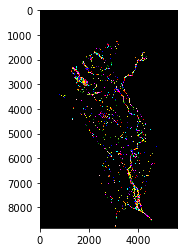

In [9]:
segments_rgb = label2rgb(segments, bg_label=0)
plt.imshow(segments_rgb, interpolation='none')

We save both the `segments` and the `segments_rgb` to disk.

In [10]:
p = profile.copy()
p['dtype'] = 'int32'
with rasterio.open(site_dir/f'segments_{site_name}.tif', 'w', **p) as ds:
    ds.write(segments.astype(np.int32), 1)

p = profile.copy()
p['dtype'] = 'float32'
p['count'] = 3
with rasterio.open(site_dir/f'segments_rgb_{site_name}.tif', 'w', **p) as ds:
    ds.write(segments_rgb.transpose([2, 0, 1]).astype(np.float32))

## Obtaining the Undirected Network

In [11]:
chanG_undirected = get_undirected_channel_network(segments, 
                                                  dist, 
                                                  profile, 
                                                  interface_adj_segments,
                                                  connectivity=8)

adding edges: 100%|██████████| 29856/29856 [00:00<00:00, 180876.24it/s]


## Obtaining the Directed Network

In [12]:
chanG = direct_channel_network(chanG_undirected, 
                               # The keywords below are how the pruning occurs
                               # Specifies pruning will be done
                               remove_dangling=True, 
                               # Do not prune nodes within 1 km of interface
                               interface_buffer_m=1_000,     
                               # Remove edge groups with an degree 1 endpoint and size <=3
                               group_min_size=5,
                               # How many times to do this pruning
                               dangling_iterations=1
                               )

Let's do a quick sanity check.

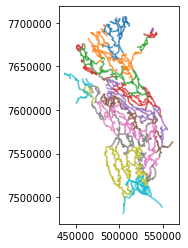

In [13]:
df_edges = export_edges_to_geodataframe(chanG, profile['crs'])
df_edges.plot(column='segment_id', categorical=True)

## Obtaining the Widths

### Using the distance transform

We are going to use the distance transform within a segment. We have a function that determines the width according to $2\cdot d - 1$ where d is the distance to the land mask according to the distance transform in a small 1-pixel buffer around the segment (if this is 0, we use the full distance transform on the channel mask).

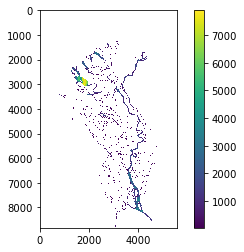

In [14]:
width_features = get_width_features_from_segments(segments, profile)
widths = get_array_from_features(segments, width_features)
plt.imshow(widths, interpolation='none')
plt.colorbar()

We now add these attributes to the graph.

In [15]:
chanG = add_width_features_to_graph(chanG, width_features.ravel())
node_data =dict(chanG.nodes(data=True))
random.choice(list(node_data.items()))

((540462.5, 7575260.0),
 {'label': 19373,
  'meters_to_interface': 90847.54961447642,
  'x': 540462.5,
  'y': 7575260.0,
  'interface_adj': False,
  'graph_degree': 2,
  'cc_id': 0,
  'width_from_segment': 54.852813742385706})

### Using $\nabla \varphi$

We compute width using the gradient of the distance function (and possibly the network structure). First we obtain the orientation of along wich to obtain these measured widths (perpendicular to the artificial flow).

In [16]:
chanG = add_flow_attributes(chanG, dist, profile['transform'])

flow vector computation using network: 100%|██████████| 29023/29023 [00:02<00:00, 11471.03it/s]


To perform intersection, we must extract the polygons of the segments. This takes a bit of time to polygonize the segments, so be patient.

In [17]:
%%time

df_segments = get_segment_df(segments, chanG, profile)
df_segments.head()

CPU times: user 25.7 s, sys: 369 ms, total: 26.1 s
Wall time: 26 s


,label,geometry,perimeter,node,flow_vector_perp
0,1,"POLYGON ((506490 7707810, 506490 7707780, 5064...",2040.0,"(506200.54054054053, 7707611.3513513515)","(0.9724516, 0.23310483)"
1,2,"POLYGON ((505080 7707690, 505080 7707660, 5050...",4260.0,"(504491.3095238095, 7707259.523809524)","(0.998991568985452, 0.04489816361483868)"
2,3,"POLYGON ((506520 7707660, 506520 7707630, 5064...",2160.0,"(506263.36363636365, 7707473.181818182)","(0.9492476, 0.31452978)"
3,4,"(POLYGON ((507450 7707630, 507420 7707630, 507...",7140.0,"(508104.7368421053, 7706691.804511278)","(0.44568253, -0.8951911)"
4,5,"(POLYGON ((505140 7707510, 505140 7707450, 505...",4020.0,"(504499.1304347826, 7707085.507246377)","(0.9204698, 0.39081362)"


We will save the geometries to a file for later inspection.

In [18]:
# From https://gist.github.com/mhweber/cf36bb4e09df9deee5eb54dc6be74d26

df_segments_out = df_segments.explode()
df_segments_out.head()

label  perimeter                                      node  \
0 0      1     2040.0  (506200.54054054053, 7707611.3513513515)   
1 0      2     4260.0    (504491.3095238095, 7707259.523809524)   
2 0      3     2160.0   (506263.36363636365, 7707473.181818182)   
3 0      4     7140.0    (508104.7368421053, 7706691.804511278)   
  1      4     7140.0    (508104.7368421053, 7706691.804511278)   

                             flow_vector_perp  \
0 0                   (0.9724516, 0.23310483)   
1 0  (0.998991568985452, 0.04489816361483868)   
2 0                   (0.9492476, 0.31452978)   
3 0                  (0.44568253, -0.8951911)   
  1                  (0.44568253, -0.8951911)   

                                              geometry  
0 0  POLYGON ((506490 7707810, 506490 7707780, 5064...  
1 0  POLYGON ((505080 7707690, 505080 7707660, 5050...  
2 0  POLYGON ((506520 7707660, 506520 7707630, 5064...  
3 0  POLYGON ((507450 7707630, 507420 7707630, 5074...  
  1  POLYGON ((507480 7707570, 507510 7707570, 5075...

In [19]:
# From: https://gist.github.com/mhweber/cf36bb4e09df9deee5eb54dc6be74d26
# To make multipolygons --> polygons after merging them.

def explode(gdf):
    """ 
    Explodes a geodataframe 
    
    Will explode muti-part geometries into single geometries. Original index is
    stored in column level_0 and zero-based count of geometries per multi-
    geometry is stored in level_1
    
    Args:
        gdf (gpd.GeoDataFrame) : input geodataframe with multi-geometries
        
    Returns:
        gdf (gpd.GeoDataFrame) : exploded geodataframe with a new index 
                                 and two new columns: level_0 and level_1
        
    """
    gs = gdf.explode()
    gdf2 = gs.reset_index().rename(columns={0: 'geometry'})
    gdf_out = gdf2.merge(gdf.drop('geometry', axis=1), left_on='level_0', right_index=True)
    gdf_out = gdf_out.set_index(['level_0', 'level_1']).set_geometry('geometry')
    gdf_out.crs = gdf.crs
    return gdf_out

In [20]:
df_segments_out = split_tuple_pairs(df_segments)
df_segments_out = explode(df_segments_out)
df_segments_out.to_file(site_dir/'segments.geojson', 
                        driver='GeoJSON')

/Users/cmarshak/anaconda3/lib/python3.7/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():


Now we extract the widths are associated geometry. This is the most expensive computation in the notebook, so be very patient. Could take 5 minutes or so.

In [21]:
%%time

df_geo_widths = get_geo_width_df(df_segments, chanG, radius=1)
df_geo_widths.head()

CPU times: user 1min 24s, sys: 289 ms, total: 1min 24s
Wall time: 1min 25s


,label,node,geometry,width_m
0,1,"(506200.54054054053, 7707611.3513513515)","LINESTRING (506520.00001 7707687.928470092, 50...",634.600687
1,2,"(504491.3095238095, 7707259.523809524)","LINESTRING (504960.00001 7707280.588393838, 50...",450.454272
2,3,"(506263.36363636365, 7707473.181818182)","LINESTRING (506580.00001 7707578.09814138, 505...",632.079571
3,4,"(508104.7368421053, 7706691.804511278)","LINESTRING (508050.00001 7706801.748071255, 50...",154.438467
4,5,"(504499.1304347826, 7707085.507246377)","LINESTRING (504960.00001 7707281.183522252, 50...",1108.129767


Let's save the widths again for later inspection.

In [22]:
df_geo_widths_out = split_tuple_pairs(df_geo_widths)
df_geo_widths_out = explode(df_geo_widths_out)
df_geo_widths_out.to_file(site_dir/'width_geometries.geojson', 
                          driver='GeoJSON')

We update the node attributes. And we see all of the attributes we have added.

In [23]:
chanG = update_graph_with_widths(chanG, df_geo_widths)

node_data =dict(chanG.nodes(data=True))
random.choice(list(node_data.items()))

((532127.3684210526, 7598432.98245614),
 {'label': 15138,
  'meters_to_interface': 67502.63917727376,
  'x': 532127.3684210526,
  'y': 7598432.98245614,
  'interface_adj': False,
  'graph_degree': 2,
  'cc_id': 0,
  'width_from_segment': 937.4709297958259,
  'flow_vector_perp_grad': (0.24091133, 0.97054714),
  'flow_vector_network': (0.9900715437642892, 0.14056435617964214),
  'flow_vector_perp_network': (-0.14056435617964214, 0.9900715437642892),
  'flow_vector_perp': (0.24091133, 0.97054714),
  'width_m': 1020.043221184196})

# Save Network

We now save the nodes and edges to `geojson` files and serialize the NetworkX `DiGraph` with `pickle`.

In [24]:
df_nodes = export_nodes_to_geodataframe(chanG, profile['crs'])
# If df_nodes is not writing, then drop columns with tuples
# We found that flow_vector_perp may not be defined in some 
# of the segments near channels and `split tuple pairs` only 
# inspects the first row of each column
df_nodes = split_tuple_pairs(df_nodes)

In [25]:
df_edges = export_edges_to_geodataframe(chanG, profile['crs'])

In [26]:
df_edges.to_file(site_dir/f'{site_name}_edges.geojson', driver='GeoJSON')
df_nodes['interface_adj'] = df_nodes.interface_adj.astype(int)
df_nodes.to_file(site_dir/f'{site_name}_nodes.geojson', driver='GeoJSON')
nx.write_gpickle(chanG, site_dir/f'{site_name}_network.pkl')